In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import islice
import skinematics_adapted as skin_a
import skinematics as skin

import sys
import tkinter as tk
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from sys import _getframe
from os.path import expanduser, join

from mpl_toolkits.mplot3d import axes3d    
import matplotlib.animation as animation

import os
import sys

file_dir = os.path.dirname("Pison_Interview_Challenge")
if file_dir not in sys.path:
    sys.path.insert(0, file_dir)

import vector

import pygame
import OpenGL.GL as gl
import OpenGL.GLU as glu

# Gesture Reconstruction

In [2]:
data = pd.read_csv("./outputs/updated_data_02.csv")

## Quaternion Reconstruction

In [3]:
quat_data = data[["timestamp","quat_x","quat_y","quat_z","quat_w","label"]]

In [4]:
quat_data

,timestamp,quat_x,quat_y,quat_z,quat_w,label
0,1514824.503,0.321960,-0.596619,-0.621826,0.392090,0
1,1514827.496,0.321960,-0.596741,-0.621826,0.392029,0
2,1514830.493,0.321960,-0.596741,-0.621765,0.391968,0
3,1514833.500,0.321960,-0.596741,-0.621765,0.391968,0
4,1514836.498,0.321960,-0.596802,-0.621765,0.391907,0
...,...,...,...,...,...,...
14976,1618167.393,-0.312927,-0.112427,-0.932861,0.138855,4
14977,1618170.388,-0.312927,-0.112427,-0.932861,0.138855,4
14978,1618173.377,-0.264465,-0.108093,-0.946472,0.150146,4
14979,1618176.442,-0.218140,-0.103271,-0.956909,0.161560,4


### Iterate through quaternion df rows, plotting orientation
> slice has 17 step, because resultant animation duration is the same as actually gesture duration

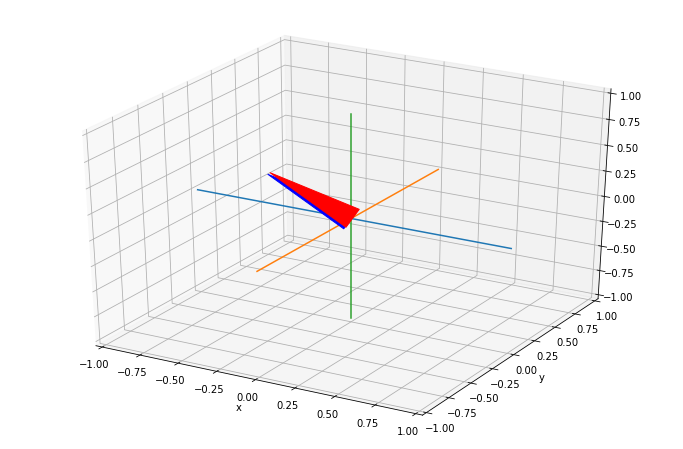

In [7]:
for index, row in islice(quat_data.iterrows(),0,None,17):
    print(quat_data['label'][index])
    clear_output(wait=True)
    q0 = np.array([[row["quat_w"], row["quat_x"], row["quat_y"], row["quat_z"]]])
    # call function from adaption skinematics script
    skin_a.orientation(q0, None, '', deltaT=1000./100)


## Position Reconstruction
> apply kalman filtering as opposed to simply double integrating. Accelerometer variance estimated. Color coded according to different gestures perceived in quaternion reconstruction. Plot 1 trace per trial

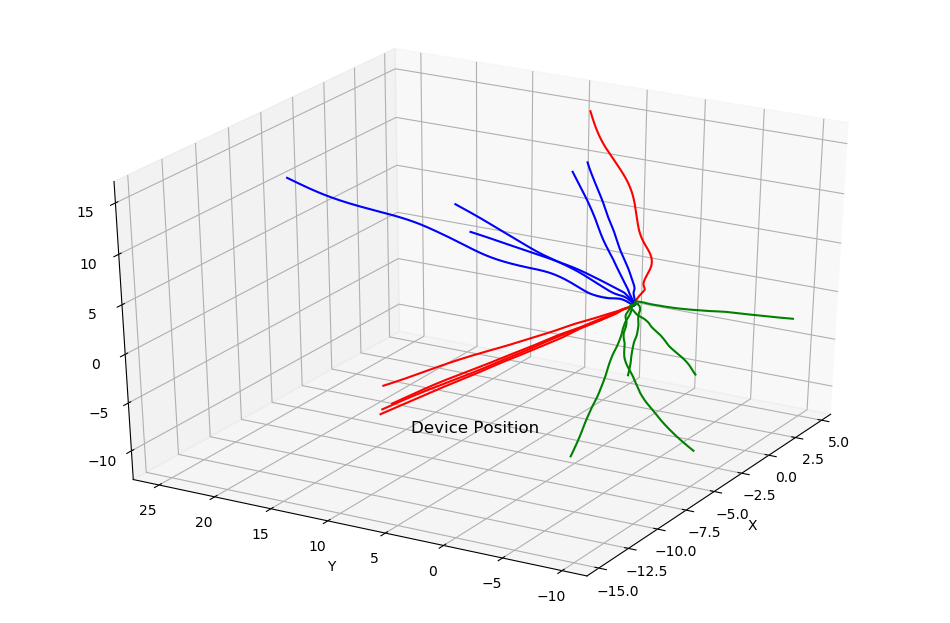

In [6]:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position

from pykalman import KalmanFilter

colors = ["red", "red" , "red", "red", "red", "blue", "blue", "blue", "blue", "blue", "green", "green", "green", "green", "green"]
ncolor = 0
axes = ["acc_x", "acc_y", "acc_z"]

fig = plt.figure(figsize=(12,8), dpi= 100)
ax = fig.gca(projection='3d')

for trial in range(1,16):
    for axis in axes:

        # Data description
        Time = data[(data.trial == trial)].timestamp

        AccX_Value = np.array([data[(data.trial == trial)][axis] - data[(data.trial == trial)][axis].iloc[0],]).T
        AccX_Variance = 0.0005

        # time step
        dt = 0.003

        # transition_matrix  
        F = [[1, dt, 0.5*dt**2], 
             [0,  1,       dt],
             [0,  0,        1]]

        # observation_matrix   
        H = [0, 0, 1]

        # transition_covariance 
        Q = [[0.2,    0,      0], 
             [  0,  0.1,      0],
             [  0,    0,  10e-4]]

        # observation_covariance 
        R = AccX_Variance

        # initial_state_mean
        X0 = [0,
              0,
              AccX_Value[0, 0]]

        # initial_state_covariance
        P0 = [[  0,    0,               0], 
              [  0,    0,               0],
              [  0,    0,   AccX_Variance]]

        n_timesteps = AccX_Value.shape[0]
        n_dim_state = 3
        filtered_state_means = np.zeros((n_timesteps, n_dim_state))
        filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))

        kf = KalmanFilter(transition_matrices = F, 
                          observation_matrices = H, 
                          transition_covariance = Q, 
                          observation_covariance = R, 
                          initial_state_mean = X0, 
                          initial_state_covariance = P0)

        # iterative estimation for each new measurement
        for t in range(n_timesteps):
            if t == 0:
                filtered_state_means[t] = X0
                filtered_state_covariances[t] = P0
            else:
                filtered_state_means[t], filtered_state_covariances[t] = (
                kf.filter_update(
                    filtered_state_means[t-1],
                    filtered_state_covariances[t-1],
                    AccX_Value[t, 0]
                )
            )
        
        if axis == "acc_x":
            x = filtered_state_means[:, 0]
        elif axis == "acc_y":
            y = filtered_state_means[:, 0]
        else:
            z = filtered_state_means[:, 0]
    
    ax.plot(x, y, z, color=colors[ncolor])
    ax.view_init(30,210)
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    ax.set_title("Device Position")
    #ax.set_title(trial)
    ncolor += 1

plt.show()